<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/CNN_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import the necessary packages**

In [ ]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import tqdm
import torch.distributions as distr

In [ ]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 4.7 MB/s eta 0:00:00


In [ ]:
import torchmetrics
import torchvision
from torchvision import transforms as T
from matplotlib import pyplot as plt

In [ ]:
from torch import nn
from torch.nn import functional as F

In [ ]:
import functorch as fc
from functorch import jvp
from functools import partial

In [ ]:
import time

# **Loading and preprocessing the data**

In [ ]:
#Load the dataset
train_data = torchvision.datasets.KMNIST('./data', train=True, download=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [ ]:
# This loads data with data conversion.
train_data = torchvision.datasets.KMNIST('./data', train=True, transform=T.ToTensor())

tensor(8)


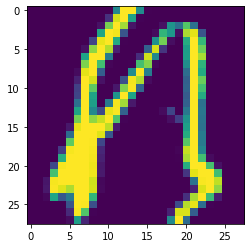

In [ ]:
# We visualize the first sample of the dataset
plt.imshow(train_data.data[0])
print(train_data.targets[0])

In [ ]:
# We use the loader to shuffle the elements of the dataset
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)

In [ ]:
# We get the first element of the loader
xb, yb = next(iter(train_loader))

In [ ]:
# Load the testset
test_data = torchvision.datasets.KMNIST('./data', train=False, transform=T.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True)

# **Define Convolutional Neural Network**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, 2, 3, padding=1)

        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)

        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*14*14, 64)

        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = x.reshape((-1, 4*14*14))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(1, -1)
        return torch.softmax(x, 1)

In [ ]:
# We check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Initialize the parameters**

In [ ]:
# We initialize the parameters randomly and the model with an input size
#conv1w = torch.FloatTensor(8, 1, 3, 3).uniform_(-1, 1)
#conv1b = torch.randint(-1, 1, (8, ), dtype=torch.float32, requires_grad=False)
#conv2w = torch.randint(-1, 1, (16, 8, 3, 3), dtype=torch.float32, requires_grad=False)
#conv2b = torch.randint(-1, 1, (16, ), dtype=torch.float32, requires_grad=False)
#fc1w = torch.randint(-1, 1, (1024, 3136), dtype=torch.float32, requires_grad=False)
#fc1b = torch.randint(-1, 1, (1024, ), dtype=torch.float32, requires_grad=False)
#fc2w = torch.randint(-1, 1, (10, 1024), dtype=torch.float32, requires_grad=False)
#fc2b = torch.randint(-1, 1, (10, ), dtype=torch.float32, requires_grad=False)
cnn = SimpleCNN(1)

In [ ]:
 # Get the functional version of the model with functorch
fcnn, params = fc.make_functional(cnn)
fcnn(params, xb)

tensor([[0.0918, 0.0953, 0.0989, 0.0881, 0.1046, 0.1094, 0.1147, 0.1054, 0.0907,
         0.1011]], grad_fn=<SoftmaxBackward0>)

In [ ]:
# We try our model with the first example
print(cnn(xb)[0])

tensor([0.0918, 0.0953, 0.0989, 0.0881, 0.1046, 0.1094, 0.1147, 0.1054, 0.0907,
        0.1011], grad_fn=<SelectBackward0>)


Calculate predictions

In [ ]:
def pred(sample_size, loader, model):
  Xtrain = torch.randn(sample_size, 1, 28, 28)
  ytrain = torch.randn(sample_size)
  ypred = torch.randn(sample_size, 10)

  for i in range(sample_size):
    xb, yb = next(iter(loader))
    Xtrain[i] = xb
    ytrain[i] = yb
    ypred[i] = model(xb)

  return Xtrain, ytrain, ypred

In [ ]:
Xtrain, ytrain, ypred ,Xtest,ytest= pred(500, train_loader, cnn)

# **Define accuracy**

In [ ]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue.long()).float().mean()

In [ ]:
# Average accuracy at initialization is 10% (random guessing).
accuracy(ytrain, ypred)

tensor(0.0940)

# **Define Cross-Entropy**

In [ ]:
def cross_entropy(params, fmodel, ytrue, x):
  ypred=torch.randn((ytrue.shape[0],10))
  for j in range(ytrue.shape[0]):
    ypred[j] = fmodel(params, x[j])
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue.long()].log().mean()

In [ ]:
print(cross_entropy(params, fcnn, ytrain, Xtrain))

tensor(2.3084, grad_fn=<NegBackward0>)


# **Other optimization functions**

In [ ]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [ ]:
def rosenbrock_function(x):
  sum=0
  for p in x.size():
    for i in range (x.size(1)-1):
      sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(x[i]-1, 2))
  return sum

# **Train and evaluate the network**

In [ ]:
def train_fwd_gradient(train_loader):

  l_rate0 = 0.015

  losses=[]
  accuracies=[]

  cnn = SimpleCNN(1)
  fcnn, params = fc.make_functional(cnn)
  Xtrain, ytrain, ypred = pred(500, train_loader, cnn)

  Xtest, ytest, ypredtest = pred(100, test_loader, cnn)


  loss = cross_entropy(params, fcnn, ytrain, Xtrain)
  t=0
  t0 = time.time()

  for epoch in range (100):

    v = tuple([torch.randn_like(p) for p in params])

    g = partial(cross_entropy, fmodel = fcnn, ytrue=ytrain, x=Xtrain)

    loss, dt = jvp(g, (params, ), (v, ))
    print('dt', dt)

    with torch.no_grad():
      for j, p in enumerate(params):
        gt = v[j]*dt
        p -= l_rate0*gt
    
    Xtest, ytest, ypredtest = pred(100, test_loader, cnn)
    print(accuracy(ytest,ypredtest).item())
    accuracies.append(accuracy(ytest,ypredtest).item())
    losses.append(cross_entropy(params,fcnn,ytest,Xtest).item())

    # We add the execution time of the iteration
    t1=time.time()
    t+=t1-t0
    t0=t1

    print('Time', t, 'loss', loss)

  return params,losses,accuracies

In [ ]:
params,losses,accuracies = train_fwd_gradient(train_loader)

dt tensor(0.0375, grad_fn=<NegBackward0>)
0.15000000596046448
Time 0.8872065544128418 loss tensor(2.3054, grad_fn=<AliasBackward0>)
dt tensor(0.0204, grad_fn=<NegBackward0>)
0.10000000149011612
Time 1.8210163116455078 loss tensor(2.3054, grad_fn=<AliasBackward0>)
dt tensor(0.0716, grad_fn=<NegBackward0>)
0.03999999910593033
Time 2.67773699760437 loss tensor(2.3054, grad_fn=<AliasBackward0>)
dt tensor(0.0501, grad_fn=<NegBackward0>)
0.12999999523162842
Time 3.6924707889556885 loss tensor(2.3053, grad_fn=<AliasBackward0>)
dt tensor(0.0068, grad_fn=<NegBackward0>)
0.10000000149011612
Time 5.000922679901123 loss tensor(2.3053, grad_fn=<AliasBackward0>)
dt tensor(-0.0314, grad_fn=<NegBackward0>)
0.07999999821186066
Time 6.149524211883545 loss tensor(2.3053, grad_fn=<AliasBackward0>)
dt tensor(0.0053, grad_fn=<NegBackward0>)
0.15000000596046448
Time 7.031855344772339 loss tensor(2.3053, grad_fn=<AliasBackward0>)
dt tensor(-0.0187, grad_fn=<NegBackward0>)
0.10000000149011612
Time 7.9190955162

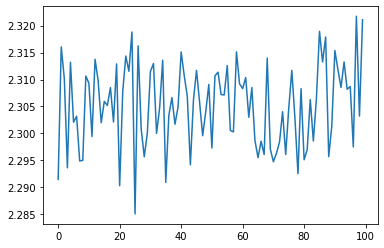

In [ ]:
plt.plot(losses)

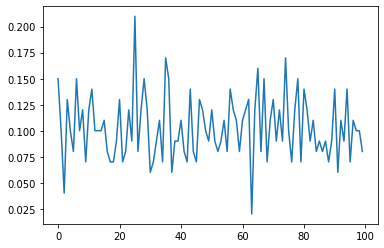

In [ ]:
plt.plot(accuracies)